## Keras Sequantial Model

In [89]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
pd.set_option('display.max_columns', 999)

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow_core.estimator import inputs
from tensorflow import feature_column
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import initializers

from tensorflow.keras.models import load_model
from keras.utils import to_categorical

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

from  IPython import display
from matplotlib import pyplot as plt

import numpy as np
import math

import pathlib
import shutil
import tempfile


### Define functions

In [313]:
def encode(i):
    switcher = {
        "H": 2,
        "D": 1,
        "A": 0,
        }
    # 1 be assigned as default value of passed argument (if goals > 5)
    return switcher.get(i, 1)

def normalize_and_encode(dataframe):
    column_names_to_not_normalize = ['result']
    column_names_to_normalize = [x for x in list(dataframe) if x not in column_names_to_not_normalize ]
    x = dataframe[column_names_to_normalize].values
    #x_scaled = preprocessing.normalize(x) vom alten
    std_scale = preprocessing.MinMaxScaler().fit(x)
    #x_train_norm = std_scale.transform(x)
    x_train_norm = x
    df_temp = pd.DataFrame(x_train_norm, columns=column_names_to_normalize, index = dataframe.index)
    dataframe[column_names_to_normalize] = df_temp

    #dataframe['result'] = dataframe.apply(lambda row: encode(row['result']), axis=1)

    le = preprocessing.LabelEncoder()
    le.fit([ "H", "D", "A"])
    dataframe.loc[:,['result']]=le.transform(dataframe['result'])
    
    return dataframe

def get_X_and_y(dataframe):
    X = dataframe.drop(columns=['result']).values
    y = dataframe[['result']].values
    return X,y


#def get_lr_schedule(train, batch_size):
    #lr_schedule = tf.keras.optimizers.SGD(lr=0.001, clipvalue=0.5)
    #tf.keras.optimizers.schedules.InverseTimeDecay(
    #0.0001, # lr??
    #decay_steps=(len(train)//batch_size)*1000,
    #decay_rate=1,
    #staircase=False)
    #return lr_schedule

def get_optimizer(train, batch_size):
    return tf.keras.optimizers.SGD(lr=0.01, momentum=0.9) 
            #tf.keras.optimizers.Adam(get_lr_schedule(train, batch_size))


def get_callbacks(name):
    return [
        tfdocs.modeling.EpochDots(),
        #tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200),
        #tf.keras.callbacks.TensorBoard(logdir/name), # Jupyter Notebook
        #tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1) # Google Colab
      ]

def compile_and_fit(model, name, X, y, validation_split, batch_size, optimizer=None, max_epochs=1000):
    if optimizer is None:
        optimizer = get_optimizer(X, batch_size)
    model.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

    model.summary()
     
    history = model.fit(
        X,
        y,
        validation_split=validation_split,
        batch_size=batch_size,
        epochs=max_epochs,
        callbacks=get_callbacks(name),
        verbose=0)
    
    model.save("../model/%s.h5" %name) 
    
    return history

def plot_history(model_history):
	plt.plot(model_history.history['accuracy'])
	plt.plot(model_history.history['val_accuracy'])
	plt.title("%s accuracy" %model_history)
	plt.ylabel('accuracy')
	plt.xlabel('epoch')
	plt.legend(['train', 'val'], loc='upper left')
	plt.show()
	
	plt.plot(model_history.history['loss'])
	plt.plot(model_history.history['val_loss'])
	plt.title("%s loss" %model_history)
	plt.ylabel('loss')
	plt.xlabel('epoch')
	plt.legend(['train', 'val'], loc='upper left')
	plt.show()

### Read the sliding window + Preprocessing

In [314]:
df02 = pd.read_csv('../data/data_classification_results/sliding02_shots.csv', sep=',', index_col=0)
df02


,result,odds-home,odds-draw,odds-away,home-wins,home-draws,home-losses,home-goals,home-opposition-goals,home-shots,home-shots_on_target,home-opposition_shots,home-opposition_shots_on_target,away-wins,away-draws,away-losses,away-goals,away-opposition-goals,away-shots,away-shots_on_target,away-opposition_shots,away-opposition_shots_on_target
0,H,3.50,3.30,2.10,1,3,6,11,16,137,67,117,53,8,2,0,15,6,161,78,72,30
1,D,2.50,3.30,2.88,3,1,6,8,16,134,64,151,77,3,3,4,11,18,104,44,87,36
2,A,1.91,3.40,4.20,4,2,4,10,15,120,58,124,56,2,2,6,11,15,134,59,100,46
3,H,3.25,3.25,2.30,5,2,3,22,12,177,82,74,37,6,3,1,19,8,169,95,113,58
4,H,1.20,6.00,19.00,7,2,1,15,8,161,72,74,31,3,2,5,10,17,143,69,134,69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7028,H,5.00,3.80,1.70,4,2,4,10,12,80,43,117,60,2,4,4,10,21,119,58,112,65
7029,H,2.00,3.60,3.70,3,2,5,9,21,89,47,92,46,1,4,5,7,21,104,55,63,26
7030,H,1.80,3.75,4.50,3,3,4,8,8,122,59,92,50,5,2,3,15,9,84,43,118,56
7031,H,1.33,5.25,9.00,2,3,5,12,14,124,62,99,50,3,3,4,11,17,103,53,122,54


In [315]:
n02 = normalize_and_encode(df02)


train02, test02 = train_test_split(n02, test_size=0.1, shuffle=False)
print(len(train02), 'train examples')
print(len(test02), 'test examples')


train_X02,train_y02 = get_X_and_y(train02)

test_X02,test_y02 = get_X_and_y(test02)

train_y02 = to_categorical(train_y02)
test_y02 = to_categorical(test_y02)

6329 train examples
704 test examples


In [316]:
n02

,result,odds-home,odds-draw,odds-away,home-wins,home-draws,home-losses,home-goals,home-opposition-goals,home-shots,home-shots_on_target,home-opposition_shots,home-opposition_shots_on_target,away-wins,away-draws,away-losses,away-goals,away-opposition-goals,away-shots,away-shots_on_target,away-opposition_shots,away-opposition_shots_on_target
0,2,3.50,3.30,2.10,1.0,3.0,6.0,11.0,16.0,137.0,67.0,117.0,53.0,8.0,2.0,0.0,15.0,6.0,161.0,78.0,72.0,30.0
1,1,2.50,3.30,2.88,3.0,1.0,6.0,8.0,16.0,134.0,64.0,151.0,77.0,3.0,3.0,4.0,11.0,18.0,104.0,44.0,87.0,36.0
2,0,1.91,3.40,4.20,4.0,2.0,4.0,10.0,15.0,120.0,58.0,124.0,56.0,2.0,2.0,6.0,11.0,15.0,134.0,59.0,100.0,46.0
3,2,3.25,3.25,2.30,5.0,2.0,3.0,22.0,12.0,177.0,82.0,74.0,37.0,6.0,3.0,1.0,19.0,8.0,169.0,95.0,113.0,58.0
4,2,1.20,6.00,19.00,7.0,2.0,1.0,15.0,8.0,161.0,72.0,74.0,31.0,3.0,2.0,5.0,10.0,17.0,143.0,69.0,134.0,69.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7028,2,5.00,3.80,1.70,4.0,2.0,4.0,10.0,12.0,80.0,43.0,117.0,60.0,2.0,4.0,4.0,10.0,21.0,119.0,58.0,112.0,65.0
7029,2,2.00,3.60,3.70,3.0,2.0,5.0,9.0,21.0,89.0,47.0,92.0,46.0,1.0,4.0,5.0,7.0,21.0,104.0,55.0,63.0,26.0
7030,2,1.80,3.75,4.50,3.0,3.0,4.0,8.0,8.0,122.0,59.0,92.0,50.0,5.0,2.0,3.0,15.0,9.0,84.0,43.0,118.0,56.0
7031,2,1.33,5.25,9.00,2.0,3.0,5.0,12.0,14.0,124.0,62.0,99.0,50.0,3.0,3.0,4.0,11.0,17.0,103.0,53.0,122.0,54.0


In [317]:
byhomegoal = df02.groupby('result')
byhomegoal.size().sort_values(ascending=False)

result
2    3238
0    2035
1    1760
dtype: int64

In [318]:
fdA = df02[df02.result == 0].head(1760)
fdD = df02[df02.result == 1].head(1760)
fdH = df02[df02.result == 2].head(1760)
df02 = pd.concat([fdA, fdD])
df02 = pd.concat([df02, fdH])

df02

,result,odds-home,odds-draw,odds-away,home-wins,home-draws,home-losses,home-goals,home-opposition-goals,home-shots,home-shots_on_target,home-opposition_shots,home-opposition_shots_on_target,away-wins,away-draws,away-losses,away-goals,away-opposition-goals,away-shots,away-shots_on_target,away-opposition_shots,away-opposition_shots_on_target
2,0,1.91,3.40,4.20,4.0,2.0,4.0,10.0,15.0,120.0,58.0,124.0,56.0,2.0,2.0,6.0,11.0,15.0,134.0,59.0,100.0,46.0
5,0,2.38,3.30,3.00,3.0,3.0,4.0,9.0,11.0,102.0,47.0,133.0,77.0,4.0,2.0,4.0,11.0,13.0,126.0,59.0,122.0,59.0
6,0,2.60,3.25,2.80,4.0,1.0,5.0,15.0,16.0,125.0,63.0,153.0,73.0,4.0,3.0,3.0,13.0,16.0,103.0,51.0,138.0,76.0
7,0,2.25,3.25,3.40,5.0,2.0,3.0,15.0,17.0,89.0,37.0,173.0,73.0,2.0,2.0,6.0,7.0,12.0,128.0,64.0,148.0,74.0
9,0,1.70,3.80,5.00,6.0,2.0,2.0,17.0,11.0,95.0,42.0,143.0,73.0,3.0,2.0,5.0,9.0,15.0,105.0,51.0,160.0,79.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3747,2,1.70,3.80,4.75,3.0,3.0,4.0,15.0,16.0,121.0,64.0,98.0,61.0,3.0,3.0,4.0,10.0,12.0,99.0,42.0,112.0,63.0
3749,2,2.38,3.30,2.90,4.0,3.0,3.0,7.0,11.0,129.0,67.0,125.0,52.0,5.0,2.0,3.0,24.0,17.0,123.0,55.0,129.0,65.0
3750,2,1.80,3.50,4.50,10.0,0.0,0.0,23.0,1.0,182.0,83.0,68.0,32.0,5.0,3.0,2.0,14.0,11.0,131.0,55.0,100.0,48.0
3751,2,1.50,4.00,7.00,6.0,2.0,2.0,16.0,9.0,142.0,76.0,87.0,43.0,1.0,3.0,6.0,7.0,16.0,112.0,54.0,116.0,54.0


In [319]:
byhomegoal = df02.groupby('result')
byhomegoal.size().sort_values(ascending=False)

result
2    1760
1    1760
0    1760
dtype: int64

train02, test02 = train_test_split(df02, test_size=0.1, shuffle=False)
print(len(train02), 'train examples')
print(len(test02), 'test examples')


train_X02,train_y02 = get_X_and_y(train02)

test_X02,test_y02 = get_X_and_y(test02)

train_y02 = to_categorical(train_y02)
test_y02 = to_categorical(test_y02)

In [320]:
train_y02

array([[0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.]], dtype=float32)

### Define the model

In [ ]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)


BATCH_SIZE = 128*8
EPOCHS=10000
validation_split = 0.2
size_histories = {}

model02_H3_M = tf.keras.Sequential([
  layers.Dense(35, activation='relu',input_shape=(train_X02.shape[1],)), # 21 features
  layers.Dropout(0.2),
  layers.Dense(20, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(10, activation='relu'),
  #layers.Dropout(0.2),
  layers.Dense(3, activation='softmax'),
  
])

In [321]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)


BATCH_SIZE = 128*8
EPOCHS=10000
validation_split = 0.2
size_histories = {}

model02_H3_M = tf.keras.Sequential([
  layers.Dense(35, activation='relu',input_shape=(train_X02.shape[1],)), # 21 features
  layers.Dropout(0.2),
  layers.Dense(20, activation='relu',kernel_initializer=initializers.RandomNormal(stddev=0.01),
  bias_initializer=initializers.Zeros()),
  layers.Dropout(0.2),
  layers.Dense(10, activation='relu',kernel_initializer=initializers.RandomNormal(stddev=0.01),
  bias_initializer=initializers.Zeros()),
  #layers.Dropout(0.2),
  layers.Dense(3, activation='softmax', kernel_initializer=initializers.RandomNormal(stddev=0.01),
  bias_initializer=initializers.Zeros()),
  
])

In [322]:
model02_H3_M.compile(optimizer="Adam", loss='categorical_crossentropy', metrics=[ "acc"])

In [323]:
predictedResult = model02_H3_M.predict(test_X02, batch_size=BATCH_SIZE)
predictedResult

array([[0.33297965, 0.3338584 , 0.33316192],
       [0.33310845, 0.33377004, 0.33312148],
       [0.33304864, 0.33390352, 0.33304778],
       ...,
       [0.33303735, 0.33375633, 0.3332064 ],
       [0.33301798, 0.33383888, 0.33314306],
       [0.33295766, 0.33392623, 0.3331161 ]], dtype=float32)

In [324]:
ynew = model02_H3_M.predict_classes(test_X02)
ynew

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [325]:
size_histories['model02_H3_M'] = compile_and_fit(model02_H3_M, 'model02_H3_M', train_X02, train_y02, validation_split=validation_split,batch_size=BATCH_SIZE, max_epochs=EPOCHS)

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_88 (Dense)             (None, 35)                770       
_________________________________________________________________
dropout_44 (Dropout)         (None, 35)                0         
_________________________________________________________________
dense_89 (Dense)             (None, 20)                720       
_________________________________________________________________
dropout_45 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_90 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_91 (Dense)             (None, 3)                 33        
Total params: 1,733
Trainable params: 1,733
Non-trainable params: 0
___________________________________________________

....................................................................................................
Epoch: 3800, accuracy:0.5372,  loss:0.9611,  val_accuracy:0.4961,  val_loss:1.0091,  
....................................................................................................
Epoch: 3900, accuracy:0.5471,  loss:0.9508,  val_accuracy:0.5024,  val_loss:1.0087,  
....................................................................................................
Epoch: 4000, accuracy:0.5418,  loss:0.9586,  val_accuracy:0.4929,  val_loss:1.0108,  
....................................................................................................
Epoch: 4100, accuracy:0.5457,  loss:0.9578,  val_accuracy:0.4961,  val_loss:1.0053,  
....................................................................................................
Epoch: 4200, accuracy:0.5422,  loss:0.9539,  val_accuracy:0.4992,  val_loss:1.0072,  
.................................................................

....................................................................................................
Epoch: 8200, accuracy:0.5477,  loss:0.9484,  val_accuracy:0.4968,  val_loss:1.0361,  
....................................................................................................
Epoch: 8300, accuracy:0.5499,  loss:0.9474,  val_accuracy:0.4897,  val_loss:1.0390,  
....................................................................................................
Epoch: 8400, accuracy:0.5404,  loss:0.9538,  val_accuracy:0.4889,  val_loss:1.0362,  
....................................................................................................
Epoch: 8500, accuracy:0.5422,  loss:0.9491,  val_accuracy:0.4913,  val_loss:1.0448,  
....................................................................................................
Epoch: 8600, accuracy:0.5398,  loss:0.9539,  val_accuracy:0.4945,  val_loss:1.0352,  
.................................................................

### Load and test the model

In [326]:
model = load_model('../model/model02_H3_M.h5')
score = model.evaluate(test_X02, test_y02, verbose=3)
print("model02_H3_M")
print("Loss:", score[0])
print("Test Accuracy:", score[1])

model02_H3_M
Loss: 1.0147420980713584
Test Accuracy: 0.50852275


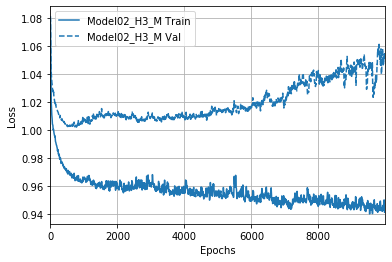

In [327]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'loss', smoothing_std=10)
plotter.plot(size_histories)

In [328]:
predictedResult = model.predict(test_X02, batch_size=1)

In [329]:
predictedResult

array([[3.8841940e-02, 1.2050309e-08, 9.6115810e-01],
       [1.6268614e-01, 2.7122736e-01, 5.6608647e-01],
       [5.0191069e-01, 2.7644601e-01, 2.2164334e-01],
       ...,
       [1.5602811e-01, 2.6136008e-01, 5.8261180e-01],
       [1.1355428e-01, 2.2485831e-01, 6.6158742e-01],
       [2.0584255e-01, 2.7925715e-01, 5.1490027e-01]], dtype=float32)

In [330]:
ynewtrin = model.predict_classes(train_X02)
ynewtrin

array([0, 0, 2, ..., 0, 0, 2], dtype=int64)

Prob: Predicting only two classes instead of 3!

In [331]:
ynew = model.predict_classes(test_X02)
ynew

array([2, 2, 0, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2,
       2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 1, 0, 2, 2, 0, 0, 2, 2, 2, 2, 2,
       0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 0, 2, 2, 0, 0, 2,
       2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 0, 2,
       0, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 1, 2, 0, 2, 0, 2, 0, 0, 2, 2,
       2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 0, 2, 2, 0, 2, 0, 2, 2,
       2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 0, 0, 2, 0, 2, 2, 2, 2,
       2, 2, 0, 2, 0, 2, 2, 0, 0, 2, 2, 2, 0, 2, 2, 2, 0, 0, 2, 2, 2, 2,
       2, 0, 2, 2, 0, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2,
       2, 0, 2, 2, 0, 0, 2, 0, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 0, 0, 2, 0,
       2, 1, 2, 2, 0, 0, 0, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 1, 2,
       2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 0, 2, 2, 0,
       2, 0, 2, 0, 2, 2, 0, 2, 2, 2, 2, 0, 0, 2, 2,

In [332]:
test_y02 

array([[0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)